In [2]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glicko2 import Player


# Import csv file

fighter_df = pd.read_csv('C:/Users/12152/Box/Other/full_fight_df.csv')

In [12]:
# Step 1 Set up fighter Glicko profiles
glicko_ratings = {} # Maps fighter name  to Player object

# Step 2 Creat log of ratings over time
rating_history = []

# Step 3: Loop through each fight
for _, row in fighter_df.iterrows():
    f1 = row['fighter']
    f2 = row['opponent']
    outcome = row['result']

    # Initialize Player objects
    if f1 not in glicko_ratings:
        glicko_ratings[f1] = Player()
    if f2 not in glicko_ratings:
        glicko_ratings[f2] = Player()
    
    p1 = glicko_ratings[f1]
    p2 = glicko_ratings[f2]

    # Fight outcomes
    if outcome == 'Win':
        score_p1, score_p2 = 1.0, 0.0
    elif outcome == 'Loss':
        score_p1, score_p2 = 0.0, 1.0
    else: # draw
        score_p1, score_p2 = 0.5, 0.5
    
    # Update both players
    p1.update_player([p2.getRating()], [p2.getRd()], [score_p1])
    p2.update_player([p1.getRating()], [p1.getRd()], [score_p2])

    # Store rating history
    rating_history.append({
        'date':row['date'],
        'fighter': f1,
        'opponent': f2,
        'rating': p1.getRating(),
        'rd':p1.getRd(),
        'volatility': p1.vol,
        'result': outcome
    })

# Step 4 Convert to Dataframe
glicko_df = pd.DataFrame(rating_history)

In [18]:
print(glicko_df.describe())

             rating            rd    volatility
count  54332.000000  54332.000000  54332.000000
mean    1810.369771    134.652405      0.059990
std      179.295445     59.682300      0.000014
min      949.189932     62.004775      0.059807
25%     1693.011335     86.457012      0.059986
50%     1809.066588    115.319685      0.059994
75%     1922.393933    171.089417      0.059998
max     2508.288095    342.746736      0.060032


In [19]:
# Max Glicko ratings
# Find the index of the row where each fighter hits their max rating
idx_max = glicko_df.groupby('fighter')['rating'].idxmax()

# Use those indices to pull full rows, including RD and date
max_rating_info = glicko_df.loc[idx_max, ['fighter', 'rating', 'rd', 'date']]

# Sort by highest max rating
max_rating_info = max_rating_info.sort_values(by='rating', ascending=False).reset_index(drop=True)

print(max_rating_info.head(25))


                  fighter       rating          rd                 date
0               Jon Jones  2508.288095   71.315753  2024-11-16 00:00:00
1          Daniel Cormier  2467.193593   75.272633  2018-11-03 00:00:00
2     Khabib Nurmagomedov  2465.634974   86.493380  2020-10-24 00:00:00
3           Lyoto Machida  2448.093354   92.483772  2009-10-24 00:00:00
4         Israel Adesanya  2445.606649   85.475488  2020-09-27 00:00:00
5       Georges St-Pierre  2427.162793   73.405729  2017-11-04 00:00:00
6          Cain Velasquez  2422.203780   81.741053  2013-10-19 00:00:00
7         Islam Makhachev  2416.751963   72.534753  2025-01-18 00:00:00
8            Ilia Topuria  2408.172817   88.686080  2024-10-26 00:00:00
9           Chris Weidman  2400.733341   89.679260  2015-05-23 00:00:00
10  Alexander Volkanovski  2400.378585   77.200615  2022-07-02 00:00:00
11           Kamaru Usman  2392.856916   72.091009  2021-11-06 00:00:00
12      Fedor Emelianenko  2386.921897   73.374905  2009-11-07 0

In [22]:
final_glicko = (
    glicko_df.groupby('fighter')
    .agg(
        final_glicko=('rating', 'last'),
        final_rd=('rd', 'last')
    )
    .sort_values(by='final_glicko', ascending=False)
    .reset_index()
)

print(final_glicko.head(25))

                  fighter  final_glicko   final_rd
0               Jon Jones   2508.288095  71.315753
1     Khabib Nurmagomedov   2465.634974  86.493380
2       Georges St-Pierre   2427.162793  73.405729
3         Islam Makhachev   2416.751963  72.534753
4            Ilia Topuria   2408.172817  88.686080
5          Daniel Cormier   2393.980588  72.144378
6           Movsar Evloev   2380.900618  89.098778
7         Francis Ngannou   2366.117481  75.185588
8         Khamzat Chimaev   2365.605836  95.839449
9          Cain Velasquez   2361.785940  77.580822
10             Ciryl Gane   2349.409533  83.547216
11      Shavkat Rakhmonov   2347.912243  91.260743
12           Stipe Miocic   2343.725258  68.882268
13  Alexander Volkanovski   2340.677969  70.179582
14           Alex Pereira   2333.543592  84.313740
15       Magomed Ankalaev   2319.308723  74.319117
16      Dricus du Plessis   2309.826207  76.124092
17           Kamaru Usman   2301.233389  69.684078
18           Max Holloway   229

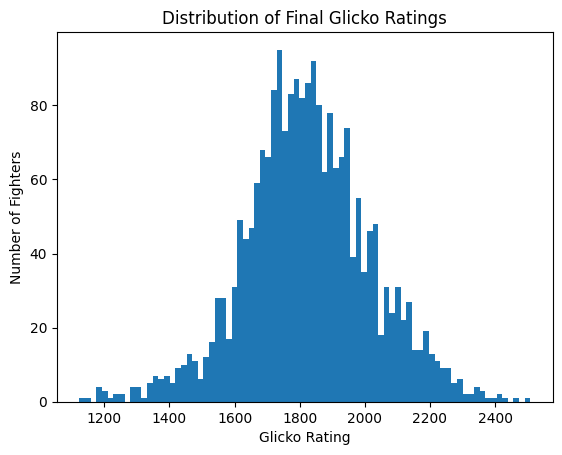

In [ ]:
plt.hist(data = final_glicko, 
         bins= 60,
         x = 'final_glicko')
plt.title("Distribution of Final Glicko Ratings")
plt.xlabel("Glicko Rating")
plt.ylabel("Number of Fighters")
plt.show()

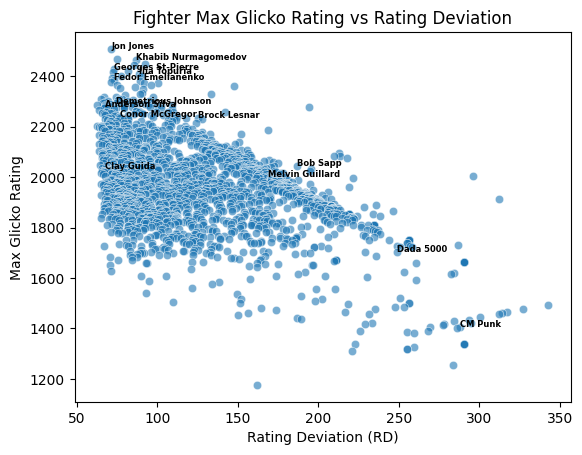

In [36]:
# Scatterplot of peak rating and RD

# Fighters you want to label (use exact names from your dataset)
highlighted = ['Jon Jones', 'Fedor Emelianenko', 'Anderson Silva', 'Georges St-Pierre', 'Khabib Nurmagomedov', 'Demetrious Johnson', 'Clay Guida', 'Conor McGregor', 'Melvin Guillard', 'Bob Sapp', 'Brock Lesnar', 'CM Punk', 'Dada 5000', 'Ilia Topuria']

for fighter in highlighted:
    if fighter in max_rating_info['fighter'].values:
        row = max_rating_info[max_rating_info['fighter'] == fighter].iloc[0]
        plt.text(row['rd'], row['rating'], fighter, fontsize=6, weight='semibold')

sns.scatterplot(data = max_rating_info,
                x = 'rd',
                y = 'rating',
                alpha = 0.6)
plt.xlabel("Rating Deviation (RD)")
plt.ylabel("Max Glicko Rating")
plt.title("Fighter Max Glicko Rating vs Rating Deviation")
plt.show()

In [16]:
# Assign a 4-month interval ID
fighter_df['date'] = pd.to_datetime(fighter_df['date'])
fighter_df = fighter_df.sort_values('date')

# Create 4-month bins (every 120 days)
start_date = fighter_df['date'].min()
fighter_df['period'] = ((fighter_df['date'] - start_date).dt.days // 180).astype(int)


# Step 1: Set up fighter Glicko profiles
glicko_ratings_2 = {}  # Maps fighter name to Player object

# Step 2: Create log of ratings over time
rating_history_2 = []

# Step 3: Loop through each monthly period
for period in sorted(fighter_df['period'].unique()):
    fights = fighter_df[fighter_df['period'] == period]

    # Track who fought this period
    active_fighters = set(fights['fighter']) | set(fights['opponent'])

    # Apply decay to inactive fighters
    for fighter in glicko_ratings_2:
        if fighter not in active_fighters:
            glicko_ratings_2[fighter].did_not_compete()

    # Loop through each fight in this period
    for _, row in fights.iterrows():
        f1 = row['fighter']
        f2 = row['opponent']
        outcome = row['result']

        # Initialize players if needed
        if f1 not in glicko_ratings_2:
            glicko_ratings_2[f1] = Player()
        if f2 not in glicko_ratings_2:
            glicko_ratings_2[f2] = Player()

        p1 = glicko_ratings_2[f1]
        p2 = glicko_ratings_2[f2]

        # Determine scores
        outcome_str = str(outcome).strip().lower()
        if outcome_str == 'win':
            score_p1, score_p2 = 1.0, 0.0
        elif outcome_str == 'loss':
            score_p1, score_p2 = 0.0, 1.0
        else:  # draw
            score_p1, score_p2 = 0.5, 0.5

        # Update ratings
        p1.update_player([p2.getRating()], [p2.getRd()], [score_p1])
        p2.update_player([p1.getRating()], [p1.getRd()], [score_p2])

        # Log rating for fighter 1 (you can log both if needed)
        rating_history_2.append({
            'date': row['date'],
            'fighter': f1,
            'opponent': f2,
            'rating': p1.getRating(),
            'rd': p1.getRd(),
            'volatility': p1.vol,
            'result': outcome
        })

# Step 4: Convert to DataFrame
glicko2_df = pd.DataFrame(rating_history_2)


In [17]:
# Max Glicko ratings
# Find the index of the row where each fighter hits their max rating
idx_max_2 = glicko2_df.groupby('fighter')['rating'].idxmax()

# Use those indices to pull full rows, including RD and date
max_rating_info_2 = glicko2_df.loc[idx_max_2, ['fighter', 'rating', 'rd', 'date']]

# Sort by highest max rating
max_rating_info_2 = max_rating_info_2.sort_values(by='rating', ascending=False).reset_index(drop=True)

print(max_rating_info_2.head(25))

                  fighter       rating          rd       date
0               Jon Jones  2518.192080   78.895098 2024-11-16
1          Daniel Cormier  2471.509114   76.300505 2018-11-03
2     Khabib Nurmagomedov  2460.104769   90.016600 2020-10-24
3           Lyoto Machida  2441.726824   94.362003 2009-10-24
4         Israel Adesanya  2436.710199   87.455526 2020-09-27
5       Georges St-Pierre  2432.415795   80.364364 2017-11-04
6          Cain Velasquez  2425.747735   82.088115 2013-10-19
7         Islam Makhachev  2425.179970   73.937707 2025-01-18
8           Chris Weidman  2410.594214   89.424100 2015-05-23
9   Alexander Volkanovski  2400.160249   77.910566 2022-07-02
10           Kamaru Usman  2396.514976   72.510499 2021-11-06
11           Ilia Topuria  2395.331511   91.618049 2024-10-26
12      Fedor Emelianenko  2385.537656   73.416437 2009-11-07
13           Stipe Miocic  2384.174124   72.997133 2020-08-15
14          Movsar Evloev  2383.555176   90.180916 2024-12-07
15      